In [1]:
import time
start = time.time()

from PIL import Image
import pandas as pd
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf


import seaborn as sns
import numpy as np
from keras.applications import ResNet50, InceptionV3, InceptionResNetV2, EfficientNetV2S
from keras.preprocessing import image
from keras.models import Model
# from tensorflow.keras.applications.resnet50 import preprocess_input
# from tensorflow.keras.applications.inception_v3 import preprocess_input
# from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


2022-08-06 20:54:27.657338: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/student/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-08-06 20:54:27.657357: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# InceptionV3: 299, 2048
# ResNet50: 224, 2048
# InceptionResNetV2: 299, 1536
# EfficientNetV2S: 384, 1280

IMG_SIZE = 384
NUMBER_OF_FEATURES = 1280

In [3]:
#Transfer tif images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
  '''
  1) Convert to RGB (but this was not done in code below)
  2) Resize image to 299 pixels (using OpenCV2) 
  3) Convert to Array (using numpy)
  '''
  IMG = []
  read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
  for IMAGE_NAME in tqdm(os.listdir(DIR)):
      PATH = os.path.join(DIR,IMAGE_NAME)
      _, ftype = os.path.splitext(PATH)
      if ftype == ".tif":

          img = read(PATH)
          
          img = cv2.resize(img, (RESIZE,RESIZE))
          
          IMG.append(np.array(img))
  return IMG

benign_data = np.array(Dataset_loader('Photos/Benign',IMG_SIZE))
insitu_data = np.array(Dataset_loader('Photos/InSitu',IMG_SIZE))
invasive_data = np.array(Dataset_loader('Photos/Invasive',IMG_SIZE))
normal_data = np.array(Dataset_loader('Photos/Normal',IMG_SIZE))

100%|██████████| 101/101 [00:02<00:00, 43.59it/s]


In [4]:
# Cancer: Benign vs InSitu vs Invasive vs Normal
# Create labels
benign_label = np.zeros(len(benign_data))
insitu_label = np.ones(len(insitu_data))
invasive_label = np.full(len(invasive_data), 2)
normal_label = np.full(len(normal_data), 3)

# Merge data
X = np.concatenate((benign_data, insitu_data, invasive_data, normal_data), axis = 0)
Y = np.concatenate((benign_label, insitu_label, invasive_label, normal_label), axis = 0)

# Shuffle data
s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
Y = Y[s]
    
# To categorical
# Y = to_categorical(Y, num_classes= 4)

In [5]:
# base_model = InceptionV3(weights='imagenet')
# base_model = ResNet50(weights='imagenet')
# base_model = InceptionResNetV2(weights='imagenet')
base_model = EfficientNetV2S(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

features_array = np.zeros((400,NUMBER_OF_FEATURES))

for i in range(len(X)):
    x = np.expand_dims(X[i], axis=0) 
    # x = tf.keras.applications.inception_v3.preprocess_input(x)
    # x = tf.keras.applications.resnet50.preprocess_input(x)
    # x = tf.keras.applications.inception_resnet_v2.preprocess_input(x)
    x = tf.keras.applications.efficientnet_v2.preprocess_input(x)
    features = model.predict(x)
    features = features.reshape(NUMBER_OF_FEATURES,)
    features_array[i,:] = features
    

2022-08-06 20:54:39.207573: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/student/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-08-06 20:54:39.207673: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/student/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-08-06 20:54:39.207725: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/student/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-08-06 20:54:39.207772: W tensorflow/stream_executor/platf

1/1 [==============================] - 0s 96ms/step


In [6]:
df =pd.DataFrame(features_array)
df['label'] = Y

## Split data into train and test

In [7]:
from sklearn.model_selection import train_test_split
X = df.drop(['label'], axis=1)
Y = df.label

'''
70% training
15% validation
15% testing

Validation to avoid overfitting.

Model is robust = when changing the training, testing & validation -> the performance doesn't change that much.
'''

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, 
    train_size=0.7, 
    random_state=0
    )

# x_val, x_test, y_val, y_test = train_test_split(
#     X_remainder, Y_remainder, 
#     train_size=0.5, 
#     random_state=11
#     )

## SVM with K-Fold

In [8]:
clf = SVC()
clf.fit(x_train, y_train)
preds = clf.predict(x_test)

print("Accuracy on test data: %.2f" %accuracy_score(y_test, preds))

Accuracy on test data: 0.78


In [9]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf, X = x_train, y = y_train, cv = 10)
print(accuracies)
print("Average accuracy for K-Fold CV: %.4f" %accuracies.mean())
# accuracies.std()

[0.82142857 0.89285714 0.78571429 0.71428571 0.75       0.89285714
 0.71428571 0.85714286 0.64285714 0.78571429]
Average accuracy for K-Fold CV: 0.7857


# Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

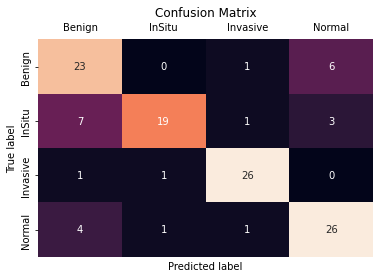

In [10]:
labels = ['Benign', 'InSitu', 'Invasive', 'Normal']

cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index = labels, columns = labels)
sns.heatmap(df_cm, annot=True, cbar=False)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

In [11]:
print(classification_report(y_test, preds, target_names=labels))

              precision    recall  f1-score   support

      Benign       0.66      0.77      0.71        30
      InSitu       0.90      0.63      0.75        30
    Invasive       0.90      0.93      0.91        28
      Normal       0.74      0.81      0.78        32

    accuracy                           0.78       120
   macro avg       0.80      0.79      0.79       120
weighted avg       0.80      0.78      0.78       120



In [12]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_test, preds, average='weighted')

(0.7977668308702791, 0.7833333333333333, 0.7830282579323752, None)

In [13]:
print('Running time: %.4f seconds' % (time.time()-start))

Running time: 70.2889 seconds
